In [289]:
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [290]:
#!unzip ./glove.6B.zip -d glove

In [291]:
#df = pd.concat(map(lambda x: pd.read_csv(x, sep="\t"), glob.glob('data/*.txt')), axis=0)

In [292]:
df = pd.read_csv("data/amazon_cells_labelled.txt", sep="\t",header=None)
df2 = pd.read_csv("data/imdb_labelled.txt", sep="\t",header=None)
df3 = pd.read_csv("data/yelp_labelled.txt", sep="\t",header=None)
df = df.append(df2)
df = df.append(df3)

In [293]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [294]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [311]:
X = []
sentences = list(df[0])
y = df[1].to_numpy()
for sen in sentences:
    X.append(preprocess_text(sen))

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [314]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [315]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [316]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [317]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [318]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [319]:
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 300, 300)          1352700   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 300, 256)          439296    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 2,186,493
Trainable params: 833,793
Non-trainable params: 1,352,700
_________________________________________________________________
None


In [320]:
history = model.fit(X_train, y_train, batch_size=100, epochs=50, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/50
18/18 [==============================] - 92s 5s/step - loss: 0.6353 - acc: 0.6473 - val_loss: 0.5149 - val_acc: 0.7727
Epoch 2/50
18/18 [==============================] - 83s 5s/step - loss: 0.4376 - acc: 0.8204 - val_loss: 0.5111 - val_acc: 0.7500
Epoch 3/50
18/18 [==============================] - 83s 5s/step - loss: 0.3789 - acc: 0.8399 - val_loss: 0.4414 - val_acc: 0.7864
Epoch 4/50
18/18 [==============================] - 83s 5s/step - loss: 0.3080 - acc: 0.8822 - val_loss: 0.4202 - val_acc: 0.7955
Epoch 5/50
18/18 [==============================] - 83s 5s/step - loss: 0.2524 - acc: 0.8987 - val_loss: 0.4224 - val_acc: 0.8045
Epoch 6/50
18/18 [==============================] - 83s 5s/step - loss: 0.2269 - acc: 0.9239 - val_loss: 0.4609 - val_acc: 0.8136
Epoch 7/50
18/18 [==============================] - 83s 5s/step - loss: 0.1896 - acc: 0.9326 - val_loss: 0.5129 - val_acc: 0.8068
Epoch 8/50
18/18 [==============================] - 82s 5s/step - loss: 0.1557 - acc: 0.94

In [321]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.3212981224060059
Test Accuracy: 0.8399999737739563


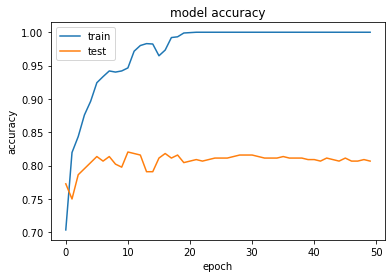

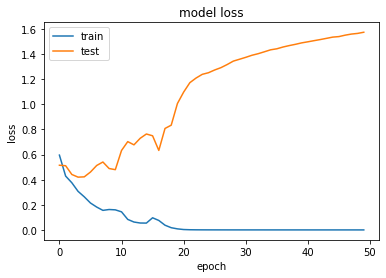

In [322]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [344]:
instance = X[2000]
print(instance)

The Greek dressing was very creamy and flavorful 


In [345]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[9.464328e-06]], dtype=float32)